## Lecture 03 - Machine Learning and Heuristic Search
Outline:
* implementing a simple machine learning model using the Titanic data
* implementing a heuristic map search with the geo coordinates of main cities in China

### 1. The Titanic Data Example

In [1]:
titanic_frame = '/Users/xinweixu/Dropbox/learn/Comp_Prog/nlp/data/titanic/train.csv'

In [2]:
import pandas as pd

train_data = pd.read_csv(titanic_frame)

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data = train_data.dropna() # remove NA values from the data set

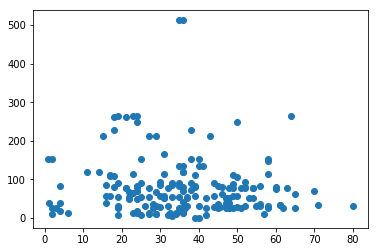

In [8]:
# suppose we want to model the relationship between 'age' and 'fare'

import matplotlib.pyplot as plt
%matplotlib inline

fares = train_data['Fare'].tolist()
ages = train_data['Age'].tolist()

plt.scatter(ages,fares)

In [9]:
# subset the data -- only considering age > 22 and 130 < fare < 400

subset_data = train_data[
    (train_data['Age'] > 22) & (train_data['Fare'] < 400) & (train_data['Fare'] > 130)
]

In [10]:
subset_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
195,196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.0,0,1,PC 17582,153.4625,C125,S
269,270,1,1,"Bissette, Miss. Amelia",female,35.0,0,0,PC 17760,135.6333,C99,S


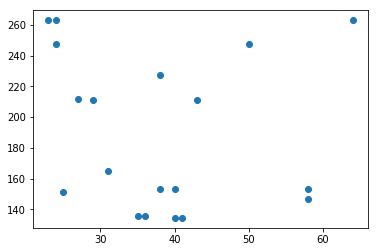

In [12]:
sub_fare = subset_data['Fare'].tolist()
sub_age = subset_data['Age'].tolist()
plt.scatter(sub_age, sub_fare)

In [47]:
# now we try to cut age into bins and calculate the average fare for each bin

bins = pd.IntervalIndex.from_tuples([(0, 20), (21, 30), (31, 40), (41,50), (51, 60), (61, 70)])
sub_age_bins = pd.cut(sub_age , bins)

# combine the age bins and fares into a data frame
sub_age_fare_df = pd.DataFrame(
    {'Age': sub_age_bins,
     'Fare': sub_fare})
                               
sub_age_fare_df.head()

,Age,Fare
0,"(21, 30]",263.0000
1,"(21, 30]",247.5208
2,"(51, 60]",146.5208
3,"(51, 60]",153.4625
4,"(31, 40]",135.6333


In [48]:
average_fare = sub_age_fare_df.groupby(['Age']).mean()
average_fare.head()
average_fare[1:6] # note that the first bin, (0, 20], contains nothing...

,Fare
Age,
"(21, 30]",224.651383
"(31, 40]",156.702767
"(41, 50]",229.429150
"(51, 60]",149.991650
"(61, 70]",263.000000


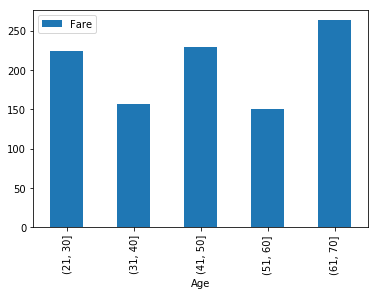

In [52]:
average_fare[1:6].plot.bar()

# note:
# see plotting from a pandas.DataFrame in documentation:
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.bar.html

In [ ]:
# see L03-titanic-example.py for implementing a basic machine learning model

### 2.  An Example for Best First Search with Map Data

In [56]:
# set up the font .ttf file so 'networkx' can recognize chinese characters

import matplotlib
print(matplotlib.__path__)

# $cd '/usr/local/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf'
# $mv SimHei.ttf DejaVuSans.ttf
# replace the DejaVuSans.ttf using SimHei.ttf

['/usr/local/lib/python3.7/site-packages/matplotlib']


In [1]:
coordinations_chinese = """
{name:'兰州', geoCoord:[103.73, 36.03]},
{name:'嘉峪关', geoCoord:[98.17, 39.47]},
{name:'西宁', geoCoord:[101.74, 36.56]},
{name:'成都', geoCoord:[104.06, 30.67]},
{name:'石家庄', geoCoord:[114.48, 38.03]},
{name:'拉萨', geoCoord:[102.73, 25.04]},
{name:'贵阳', geoCoord:[106.71, 26.57]},
{name:'武汉', geoCoord:[114.31, 30.52]},
{name:'郑州', geoCoord:[113.65, 34.76]},
{name:'济南', geoCoord:[117, 36.65]},
{name:'南京', geoCoord:[118.78, 32.04]},
{name:'合肥', geoCoord:[117.27, 31.86]},
{name:'杭州', geoCoord:[120.19, 30.26]},
{name:'南昌', geoCoord:[115.89, 28.68]},
{name:'福州', geoCoord:[119.3, 26.08]},
{name:'广州', geoCoord:[113.23, 23.16]},
{name:'长沙', geoCoord:[113, 28.21]},
//{name:'海口', geoCoord:[110.35, 20.02]},
{name:'沈阳', geoCoord:[123.38, 41.8]},
{name:'长春', geoCoord:[125.35, 43.88]},
{name:'哈尔滨', geoCoord:[126.63, 45.75]},
{name:'太原', geoCoord:[112.53, 37.87]},
{name:'西安', geoCoord:[108.95, 34.27]},
//{name:'台湾', geoCoord:[121.30, 25.03]},
{name:'北京', geoCoord:[116.46, 39.92]},
{name:'上海', geoCoord:[121.48, 31.22]},
{name:'重庆', geoCoord:[106.54, 29.59]},
{name:'天津', geoCoord:[117.2, 39.13]},
{name:'呼和浩特', geoCoord:[111.65, 40.82]},
{name:'南宁', geoCoord:[108.33, 22.84]},
//{name:'西藏', geoCoord:[91.11, 29.97]},
{name:'银川', geoCoord:[106.27, 38.47]},
{name:'乌鲁木齐', geoCoord:[87.68, 43.77]},
{name:'香港', geoCoord:[114.17, 22.28]},
{name:'澳门', geoCoord:[113.54, 22.19]}
"""

In [2]:
# now we parse info for the city geo-coordinates

import re
city_location = {} # deine an empty dictionary

for line in coordinations_chinese.split('\n'):
    if line.startswith('//'): continue # leave out cities not in mainland
    if line.strip() == '': continue
    
    city = re.findall("name:'(\w+)'", line)[0]

    x_y = re.findall("Coord:\[(\d+.\d+),\s(\d+.\d+)\]", line)[0]
    x_y = tuple(map(float, x_y)) # change geo-coord into floats
    city_location[city] = x_y
    print(city, x_y)

# notes:
# 1) python re referenes: https://docs.python.org/3/library/re.html
# 2) the map() function -- it applies a function to all the items in an input_list
#    map(function_to_apply, list_of_inputs)
# see http://book.pythontips.com/en/latest/map_filter.html


兰州 (103.73, 36.03)
嘉峪关 (98.17, 39.47)
西宁 (101.74, 36.56)
成都 (104.06, 30.67)
石家庄 (114.48, 38.03)
拉萨 (102.73, 25.04)
贵阳 (106.71, 26.57)
武汉 (114.31, 30.52)
郑州 (113.65, 34.76)
济南 (117.0, 36.65)
南京 (118.78, 32.04)
合肥 (117.27, 31.86)
杭州 (120.19, 30.26)
南昌 (115.89, 28.68)
福州 (119.3, 26.08)
广州 (113.23, 23.16)
长沙 (113.0, 28.21)
沈阳 (123.38, 41.8)
长春 (125.35, 43.88)
哈尔滨 (126.63, 45.75)
太原 (112.53, 37.87)
西安 (108.95, 34.27)
北京 (116.46, 39.92)
上海 (121.48, 31.22)
重庆 (106.54, 29.59)
天津 (117.2, 39.13)
呼和浩特 (111.65, 40.82)
南宁 (108.33, 22.84)
银川 (106.27, 38.47)
乌鲁木齐 (87.68, 43.77)
香港 (114.17, 22.28)
澳门 (113.54, 22.19)


In [3]:
import math

def geo_distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # kilometers
    
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d
    
    

In [4]:
def get_city_distance(city1, city2):
    """
    Define a procedure that returns the Haversine distance between two cities,
    where the geo-coords of these two cities are defined in a dictionary
    """
    return geo_distance(city_location[city1], city_location[city2])
    

In [5]:
# test case
get_city_distance('杭州', '上海')

153.5185697155768

In [6]:
import networkx as nx

# create a network graph using city names as nodes
cities = list(city_location.keys())
city_graph = nx.Graph()
city_graph.add_nodes_from(cities)

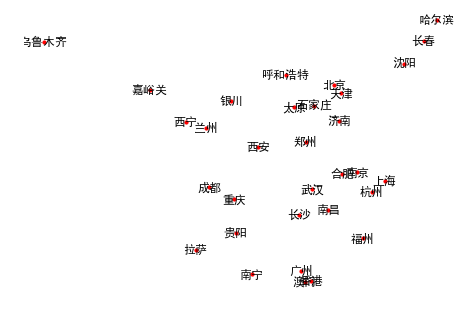

In [8]:
# draw the graph, where the location of nodes correspond to their geo-coords

nx.draw(city_graph, city_location, with_labels=True, node_size=10) 

In [10]:
# now we want to add connections to the network graph

threshold = 700 # a cutoff threshold for determining whether two cities are connected in the graph

from collections import defaultdict

cities_connection = defaultdict(list) # set up a dictionary to store connections

# loop over each city to create the connection list
for c1 in cities:
    for c2 in cities:
        if c1 == c2: continue
        
        elif get_city_distance(c1, c2) < threshold:
            cities_connection[c1].append(c2)

##########       
# notes:
# 1) defaultdict - dict subclass that calls a factory function to supply missing values
# see documentation: https://docs.python.org/3/library/collections.html
# 2) defaultdict means that if a key is not found in the dictionary, then instead of 
# a KeyError being returned, a new entry is created. 
# The type of this new entry is given by the argument of defaultdict.
# see https://stackoverflow.com/questions/5900578/how-does-collections-defaultdict-work

In [11]:
cities_connection['兰州']

['嘉峪关', '西宁', '成都', '拉萨', '贵阳', '西安', '重庆', '南宁', '银川']

In [12]:
# create a network graph using the connection list

cities_connection_graph = nx.Graph(cities_connection)

/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


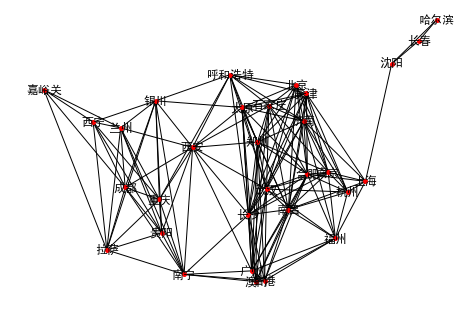

In [14]:
nx.draw(cities_connection_graph, city_location, with_labels=True, node_size=15)

In [42]:
# now we can implement the search procedure with three possible search strategies:
# --- find the shortest path between two cities
# --- find the path with the least steps we need to travel between two cities
# --- find the path that saturates the map as much as possible (i.e., the most steps)

# the procedure should do the following things:
#  --- 1) take four inputs: a city graph, the start location, destination, and search strategy
#  --- 2) search the graph to find the next city (the successor); ***
#  --- 3) check if the destination has been reached;
#  --- 4) return pathes that satisfy the search strategy

#  *** the key difference between different search strategies is to determine 
#      the criteria used for choosing which city as the successor


# we start with a simple search using BFS (reviewing lecture 01)
def search_bfs(start, destination, connection_graph):
    pathes = [[start]]
    seen = set()
    
    while pathes:
        path = pathes.pop(0) 
        frontier = path[-1] # get the current standing position
        
        if frontier in seen: continue
            
        successors = connection_graph[frontier] # get the nodes linked with frontier
        
        for city in successors: # check if we have reached the destination
            if city in path: continue
            
            new_path = path + [city]
            
            pathes.append(new_path)
            
            if city == destination: return new_path
        
        seen.add(frontier)

In [43]:
search_bfs('兰州', '上海', cities_connection)

['兰州', '西安', '石家庄', '济南', '上海']

In [44]:
# now we want to add two things to search_bfs:
# --- change the control statement, if city == destination, into a function, is_goal
# --- add search strategy

def is_goal(current_path, desitination):
    "Define a procedure that checks if the destination has been reached with the current path."
    return current_path[-1] == desitination

In [45]:
# test case 1
is_goal(['西安', '兰州', '上海'], '兰州')

False

In [51]:
# test case 2
is_goal(['西安', '上海', '兰州'], '兰州')

True

In [63]:
# modify is_goal function

def is_goal(destination):
    "Define a procedure that checks if the destination has been reached with the current path."
    def _wrap(current_path):
        return current_path[-1] == destination
    return _wrap

In [65]:
# add is_goal to the search procedure

def search_with_goal(connection_graph, start, is_goal):
    pathes = [[start]]
    seen = set()
    
    while pathes:
        path = pathes.pop(0) 
        frontier = path[-1] # get the current standing position
        
        if frontier in seen: continue
            
        successors = connection_graph[frontier] # get the nodes linked with frontier
        
        for city in successors: # check if we have reached the destination
            if city in path: continue
            
            new_path = path + [city]
            
            pathes.append(new_path)
            
            if is_goal(new_path): return new_path # change the control statement into a function
        
        seen.add(frontier)

In [66]:
search_with_goal(cities_connection, start='西安', is_goal=is_goal('上海'))

['西安', '石家庄', '济南', '上海']

In [67]:
# now we add the search strategy part
#  --- first, we need a set of functions that calculate evaluation metrics for all the feasible pathes 
#  --- second, we need a sort function to find the best one among all feasible pathes using the metric

def sort_path(cmp_func, beam=-1):
    def _sorted(pathes):
        return sorted(pathes, key=cmp_func)[:beam]
    return _sorted

# functions for different evaluation metrics
def get_path_distance(path):
    distance = 0
    
    for i, c in enumerate(path[:-1]):
        distance += get_city_distance(c, path[i+1])
        
    return distance

def get_total_station(path):
    return len(path)

def get_comprehensive_path(path):
    return get_path_distance(path) + get_total_station(path)

def get_as_much_path(path): # reversing the order of path distance
    return -1 * len(path)


In [69]:
get_path_distance(['北京', '长沙'])

665.2271362574077

In [70]:
# add search strategy to the main search function

def search(graph, start, is_goal, search_strategy):
    """
    Given a graph, a search strategy, a start location, and a destination,
    this procedure returns the path between two cities that satisfy the search strategy
    
    """
    pathes = [[start]] # initialize the path list
    seen = set() # an empty set to store the cities already searched
    
    while pathes:
        path = pathes.pop(0)
        frontier = path[-1]
        
        if frontier in seen: continue
            
        successors = graph[frontier]
        
        for city in successors:
            if city in path: continue
            
            new_path = path+[city]
            
            pathes.append(new_path)
            
            if is_goal(new_path): return new_path
        
        seen.add(frontier)
        pathes = search_strategy(pathes)
               

In [71]:
search(cities_connection, '北京', is_goal('拉萨'), search_strategy=lambda n:n)

# lambda n:n means that we didn't specify any search strategy

['北京', '长沙', '南宁', '拉萨']

In [74]:
# get path with the shortest distance

search(cities_connection, start='北京', is_goal=is_goal('拉萨'), search_strategy=sort_path(get_path_distance))

['北京', '呼和浩特', '银川', '拉萨']

In [78]:
# get path with the least number of total stations

search(cities_connection, start='北京', is_goal=is_goal('拉萨'), search_strategy=sort_path(get_total_station))

['北京', '长沙', '南宁', '拉萨']

In [80]:
# get path with the least number of total stations

search(cities_connection, start='杭州', is_goal=is_goal('拉萨'), search_strategy=sort_path(get_total_station))

['杭州', '武汉', '广州', '南宁', '拉萨']

In [81]:
# get the most comprehensive path

search(cities_connection, start='杭州', is_goal=is_goal('拉萨'), search_strategy=sort_path(get_comprehensive_path))

['杭州', '南昌', '长沙', '南宁', '拉萨']

In [82]:
# get the longest distance path

search(cities_connection, start='北京', is_goal=is_goal('拉萨'), search_strategy=sort_path(get_as_much_path))

['北京',
 '石家庄',
 '武汉',
 '郑州',
 '济南',
 '南京',
 '合肥',
 '杭州',
 '南昌',
 '福州',
 '广州',
 '长沙',
 '太原',
 '西安',
 '兰州',
 '拉萨']